# Dataset : 

https://www.kaggle.com/datasets/mathchi/diabetes-data-set/code

In [22]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv("Data/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
print("Shape:", df.shape)

Shape: (768, 9)


In [9]:
df.columns.to_list()

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [10]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [11]:
print("Descriptive stats (numeric):")
print(df.describe().T)

Descriptive stats (numeric):
                          count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   768.0  120.894531   31.972618   0.000  99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   
Outcome                   768.0    0.348958    0.476951   0.000   0.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
Glucose                   117.0000  140.25000  199.00  
BloodPressure              72.00

In [12]:
X= df.drop(columns=["Outcome"])
y= df["Outcome"]

In [15]:
print("\nClass distribution (counts):")
print(y.value_counts())


Class distribution (counts):
Outcome
0    500
1    268
Name: count, dtype: int64


In [14]:
zero_counts = (X == 0).sum()
print(zero_counts)

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


In [16]:
print(zero_counts[zero_counts > 0].sort_values(ascending=False))

Insulin          374
SkinThickness    227
Pregnancies      111
BloodPressure     35
BMI               11
Glucose            5
dtype: int64


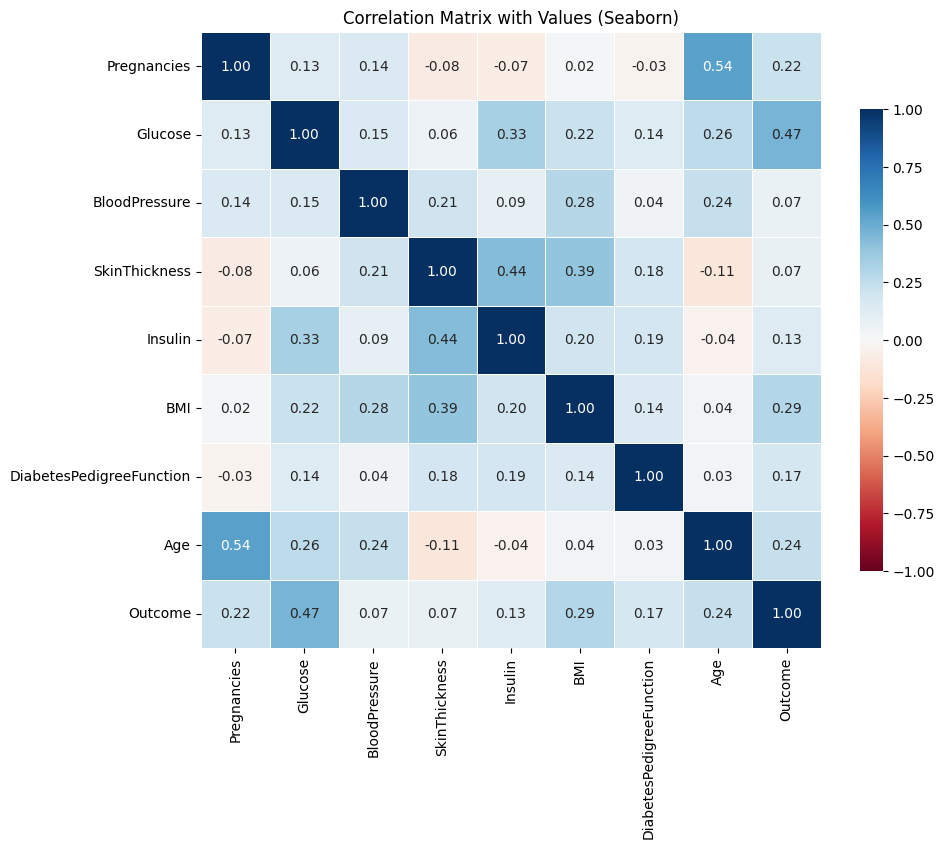

In [17]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr, annot=True, cmap='RdBu',fmt=".2f",vmin=-1,vmax=1,
    center=0,linewidths=.5,cbar_kws={"shrink": .75}
)
plt.title("Correlation Matrix with Values (Seaborn)")
plt.show()

In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.10,random_state=42)

In [19]:
print(f"After split -> X_train: {X_train.shape}, X_test: {X_test.shape}")

After split -> X_train: (691, 8), X_test: (77, 8)


In [20]:
# Step 1 : do the imputation
columns_with_zero = ["Insulin", "SkinThickness", "BloodPressure", "BMI", "Glucose"]

zero_missing_cols = [c for c in columns_with_zero if c in X_train.columns]
print("Columns with 0 for (treating 0 values as missing):", zero_missing_cols)

Columns with 0 for (treating 0 values as missing): ['Insulin', 'SkinThickness', 'BloodPressure', 'BMI', 'Glucose']


In [23]:
# Step 2 : scaling
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
remaining_cols = [c for c in numeric_cols]
print(remaining_cols)

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [24]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.compose import ColumnTransformer

In [25]:
transformers = []

if zero_missing_cols:
    impute_then_scale = SklearnPipeline([
        ("imputer_zero_as_missing", SimpleImputer(missing_values=0, strategy="median")),
        ("scaler", StandardScaler())
    ])
    transformers.append(("impute_scale", impute_then_scale, zero_missing_cols))

    # numerical colms & not part of imputation
    remaining_after_impute = [c for c in remaining_cols if c not in zero_missing_cols]
    if remaining_after_impute:
        transformers.append(("scaler_all", SklearnPipeline([("scaler", StandardScaler())]), remaining_after_impute))

else :
    transformers.append(("scaler_all", SklearnPipeline([("scaler", StandardScaler())]), remaining_cols))


In [26]:
preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")
# remainder="drop" specifies what should happend to any columns in our dataset that 
# were not explicitly included in any of transformers we defined

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
clf = LogisticRegression(solver="liblinear", max_iter=1000, random_state=42)

In [29]:
pipeline = SklearnPipeline([("preprocessor", preprocessor), ("clf", clf)])

In [30]:
pipeline.fit(X_train, y_train)
# preprocessor.fit(X_train)
# preprocessor.transform(X_train)
print("Pipeline fitted to training data.")



Pipeline fitted to training data.


In [31]:
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

In [32]:
y_train_pred, y_test_pred

(array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

In [33]:
y_train_proba = pipeline.predict_proba(X_train)[:, 1]
y_test_proba = pipeline.predict_proba(X_test)[:, 1]